In [1]:
from scipy.optimize import direct
from ultralytics import YOLO
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import seaborn as sb

In [2]:
model = YOLO('yolo11l.pt')

In [ ]:
image_path = 'results/frame.jpg'
results = model.predict(image_path)

In [ ]:
frame = cv2.imread(image_path)

In [ ]:
b_boxes = results[0].boxes.xyxy.tolist()

In [ ]:
cv2.imshow('frame', frame[int(b_boxes[2][1]):int(b_boxes[2][3]), int(b_boxes[2][0]):int(b_boxes[2][2])])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
def get_players(frame: np.ndarray, boxes: list[np.ndarray]) -> list[np.ndarray]:
    players = []
    for bbox in boxes:
        player = frame[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
        players.append(player)
    return players

In [ ]:
players = get_players(frame, results[0].boxes.xyxy.tolist())

In [ ]:
players[2].shape

In [ ]:
def get_kits(players: list[np.ndarray]) -> list[np.ndarray]:
    kits = []
    for player in players:
        kit = player[player.shape[0]//6:player.shape[0]//2, int(player.shape[1] * 0.25):int(player.shape[1] * 0.75)]
        kits.append(kit)
    return kits

In [ ]:
kits = get_kits(players)

In [ ]:
total_width = sum(kit.shape[1] for kit in kits)
max_height = max(kit.shape[0] for kit in kits)

output_image = np.zeros((max_height, total_width, 3), dtype=np.uint8)

current_x = 0
for kit in kits:
    h, w = kit.shape[:2]
    output_image[0:h, current_x:current_x+w] = kit 
    current_x += w

cv2.imshow("kits Side by Side", output_image)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.imwrite("kits.jpg", output_image)

In [ ]:
kits[2]

In [ ]:
cv2.imshow('kit1', kits[0])

In [ ]:
for i, kit in enumerate(kits):
    cv2.imwrite(f'kits/kit{i+1}.png', kits[i])

In [ ]:
cv2.imwrite('kits/kit1.png', kits[0])
cv2.imshow('kits_0', kits[0])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
def get_mean_color(kits: np.ndarray) -> list[np.ndarray]:
    mean_colors: list[int] = []
    for kit in kits:
        im = Image.fromarray(kit)
        im = im.convert('P', colors=16)
        im = np.array(im)
        mean_color = np.mean(im, axis=(0, 1))
        # color_image = np.zeros((100, 100, 3), dtype=np.uint8)
        # color_image[:] = [int(mean_color[0]), int(mean_color[1]), int(mean_color[2])]
        mean_colors.append(mean_color)
    return mean_colors

In [ ]:
means = get_mean_color(kits)
means

In [ ]:
def get_shirt_color(num: int) -> int:
    image = Image.open(f'kits/kit{num}.png')
    image = image.convert('P', palette=Image.ADAPTIVE, colors=2)
    img_colors = image.getcolors(maxcolors=2)
    print(img_colors)
    w, h = image.size
    points = [(0,0), (0, h-1), (w-1, 0), (w-1, h-1)]
    colors: list[tuple] = []
    for point in points:
        colors.append(image.getpixel(point))
    bg_color: int = max(set(colors), key=colors.count)
    shirt_index: int = 1 - bg_color
    for color in img_colors:
        if color[1] == shirt_index:
            return color[0]
    return -1

In [ ]:
kits_n = len(kits)
shirt_color = []
for i in range(kits_n):
    shirt_color.append(get_shirt_color(i+1))

In [ ]:
means

In [ ]:
y = shirt_color.copy()

In [ ]:
true = [2, 2, 2, 1, 0, 0, 1, 0, 2, 1, 0, 0, 0, 2, 1, 1, 1, 1, 1, 1, 0, 0]

In [ ]:
plt.scatter(range(1, len(means)+1), means, c=true)

In [ ]:
img_rgb = Image.open('kits/kit7.png')
img_rgb = img_rgb.convert('P', palette=Image.ADAPTIVE, colors=2)
img_rgb

In [2]:
from data_parse import DataParser
directory = 'data/SoccerNetGS/gamestate-2024/train/'
data_parser = DataParser(directory)
data_parser.parse_data_to_df()
shirts_data = data_parser.get_shirts_data()

Wczytywanie danych...


100%|██████████| 58/58 [00:12<00:00,  4.79it/s]


Tworzenie DataFrame...


100%|██████████| 57/57 [00:04<00:00, 13.15it/s]


In [15]:
shirts_data

,image_id,bbox_image_x,bbox_image_y,bbox_image_w,bbox_image_h,attributes_team
1060000001,1060000001,914,855,55,172,left
1060000002,1060000001,917,575,32,122,left
1060000003,1060000001,956,557,53,133,right
1060000004,1060000001,1257,673,44,141,right
1060000005,1060000001,1888,400,30,101,right
...,...,...,...,...,...,...
1170014150,1170000750,1567,407,30,63,left
1170014151,1170000750,419,473,61,92,right
1170014152,1170000750,1681,390,29,70,left
1170014153,1170000750,1144,455,42,83,left


In [18]:
from shirt_color import ShirtColor

In [20]:
img_id = '1113000444'
img_path = f'data/SoccerNetGS/gamestate-2024/train/SNGS-113/img1/{img_id[-6:]}.jpg'
shirts_data_test = shirts_data[shirts_data['image_id'] == img_id]
frame = cv2.imread(img_path)
b_boxes = [row for row in shirts_data_test[['bbox_image_x', 'bbox_image_y', 'bbox_image_w', 'bbox_image_h']].values]
true_values = [1 if row == 'left' else 0 for row in shirts_data_test['attributes_team'].values]
shirt_color = ShirtColor(frame, b_boxes)

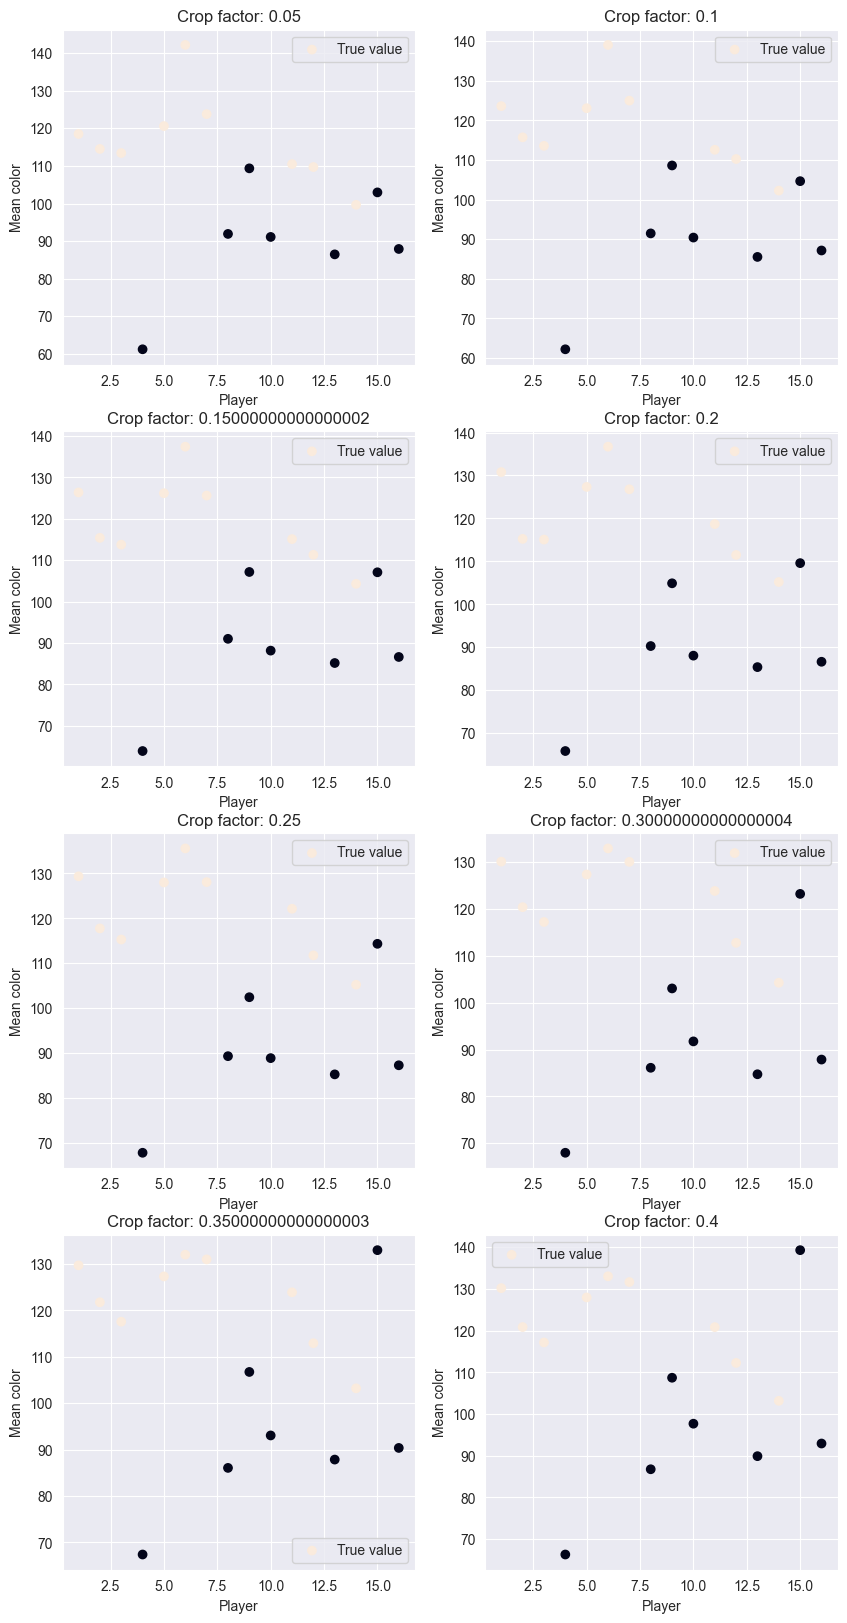

In [21]:
plt.figure(figsize=(10, 20))

for i in range(8):
    shirt_color.set_crop_factor(0.05*(i+1))
    shirt_color.get_shirt_color()
    plt.subplot(4, 2, i+1)
    shirt_color.plot_colors(true_values, True)
    plt.title(f'Crop factor: {0.05*(i+1)}')
plt.show()


In [23]:
shirt_color.set_crop_factor(0.25)
shirt_color.get_shirt_color()

[np.float64(129.3581081081081),
 np.float64(117.75465838509317),
 np.float64(115.28030303030303),
 np.float64(67.77427490542244),
 np.float64(128.0),
 np.float64(135.57692307692307),
 np.float64(128.07),
 np.float64(89.29642857142858),
 np.float64(102.42941176470588),
 np.float64(88.8603896103896),
 np.float64(122.133608815427),
 np.float64(111.75),
 np.float64(85.23908045977012),
 np.float64(105.20803571428571),
 np.float64(114.32517482517483),
 np.float64(87.26538461538462)]

In [11]:
x, y, w, h = map(lambda elem: int(elem),  b_boxes[0])

In [20]:
img = cv2.imread(img_path)
image = img[y:y+h, x:x+w]

In [9]:
asd = [1, 2, 3, 4, 5]
a, b, c, d, e = map(lambda x: x+1, asd)


2

In [25]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0).fit(np.array(shirt_color.colors).reshape(-1, 1))
labels = kmeans.labels_
labels

array([1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0], dtype=int32)

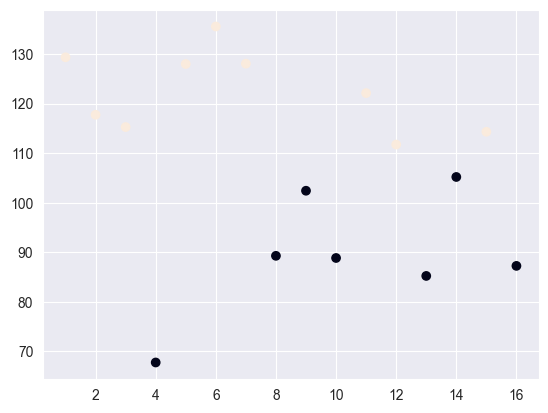

In [26]:
plt.scatter(range(1, len(shirt_color.colors) + 1), shirt_color.colors, c=labels)


In [27]:
true_values

[1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0]

In [28]:
accuracy = sum([1 if true == labels else 0 for true, labels in zip(true_values, labels)])/len(true_values)
accuracy

0.875

In [29]:
acc = np.mean(labels == true_values)
acc

np.float64(0.875)